In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
# ─── Constants ─────────────────────────────────────────────────────────────
DATA_DIR    = Path("/Users/adamcartwright/ncerdc")
POST_YEAR   = 2021

# ─── 1) Load Data ─────────────────────────────────────────────────────────
curtest  = pd.read_csv(DATA_DIR / "Student Data/Testing Data/curtest_master.csv")
cb       = pd.read_csv(DATA_DIR / "Student Data/Testing Data/collegeboard_clean.csv")
demo     = pd.read_csv(DATA_DIR / "Student Data/Demographics Data/demographics_clean.csv")
cb_full  = pd.read_csv(DATA_DIR / "Student Data/Testing Data/collegeboard_full.csv")
gpa      = pd.read_csv(DATA_DIR / "Student Data/GPA Data/gpa_cumulative_2017_2023.csv")

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_95039/3931733263.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  curtest  = pd.read_csv(DATA_DIR / "Student Data/Testing Data/curtest_master.csv")
/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_95039/3931733263.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  demo     = pd.read_csv(DATA_DIR / "Student Data/Demographics Data/demographics_clean.csv")


In [3]:
# 2) Preprocess cb and demo for merge
for df_ in (cb, demo):
    df_["mastid"] = df_["mastid"].astype(str)
    df_["year"] = df_["year"].astype(int)

cb_demo = pd.merge(
    cb, demo,
    on=["mastid", "year"],
    how="inner",
    suffixes=("_cb","_demo")
)

# Parse test date and keep as 'date'
cb_demo["sat_asmt_dt_mr"] = pd.to_datetime(cb_demo["sat_asmt_dt_mr"])
cb_demo["date"] = cb_demo["sat_asmt_dt_mr"]

# 3) Percentiles & z-scores by test date
score_cols = ["sat_total_score_mr", "sat_ebrw_score_mr", "sat_math_score_mr"]
for col in score_cols:
    pct_col = col.replace("_mr", "_pct")
    z_col = col.replace("_mr", "_z")
    cb_demo[pct_col] = cb_demo.groupby("date")[col].rank(pct=True) * 100
    cb_demo[z_col] = cb_demo.groupby("date")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# Round percentiles and z-scores
pct_cols = [c for c in cb_demo if c.endswith("_pct")]
z_cols   = [c for c in cb_demo if c.endswith("_z")]
cb_demo[pct_cols] = cb_demo[pct_cols].round(1)
cb_demo[z_cols]   = cb_demo[z_cols].round(2)

# 4) Flags & categories
cb_demo["AIG_flag"] = cb_demo["aig"].isin(["B","I","Y"]).astype(int)
cb_demo["sex_flag"] = cb_demo["sex"].map({"M":1,"F":0}).astype(int)
cb_demo["EDS_flag"] = cb_demo["eds"].map({"Y":1,"N":0}).astype(int)
cb_demo["ethnic"]   = cb_demo["ethnic"].astype('category')

# 5) Fixed-baseline z-score using 2017
baseline = cb_demo.loc[cb_demo["date"].dt.year == 2017, "sat_total_score_mr"]
mu_2017, sigma_2017 = baseline.mean(), baseline.std()
cb_demo["z_2017"] = (cb_demo["sat_total_score_mr"] - mu_2017) / sigma_2017

# 6) Save cleaned cb_demo for trajectory analysis
output_dir = DATA_DIR / "Trajectories Analysis"
output_dir.mkdir(parents=True, exist_ok=True)
cb_demo.to_csv(output_dir / "cb_demo.csv", index=False)

In [4]:
# ─── 7) Pre/post indicator & inverse‐volume weights ────────────────────────
pre_counts      = cb_demo.groupby("date").size()
avg_pre_count   = pre_counts[pre_counts.index.year < POST_YEAR].mean()
cb_demo["weight"] = cb_demo["date"].map(lambda d: avg_pre_count / pre_counts[d])

# **REPLACE** post on date → post on year
cb_demo["post"] = (cb_demo["year"] >= POST_YEAR).astype(int)

# ─── 8) Monthly summary for z_2017 and raw scores (≥1,000 tests) ──────────
monthly = (
    cb_demo
    .dropna(subset=["z_2017","sat_total_score_mr"])
    .set_index("date")
    .resample("MS")
    .agg(
        mean_z     = ("z_2017",           "mean"),
        mean_raw   = ("sat_total_score_mr","mean"),
        median_raw = ("sat_total_score_mr","median"),
        test_count = ("sat_total_score_mr","size")
    )
    .query("test_count >= 1000")
    .reset_index()
)


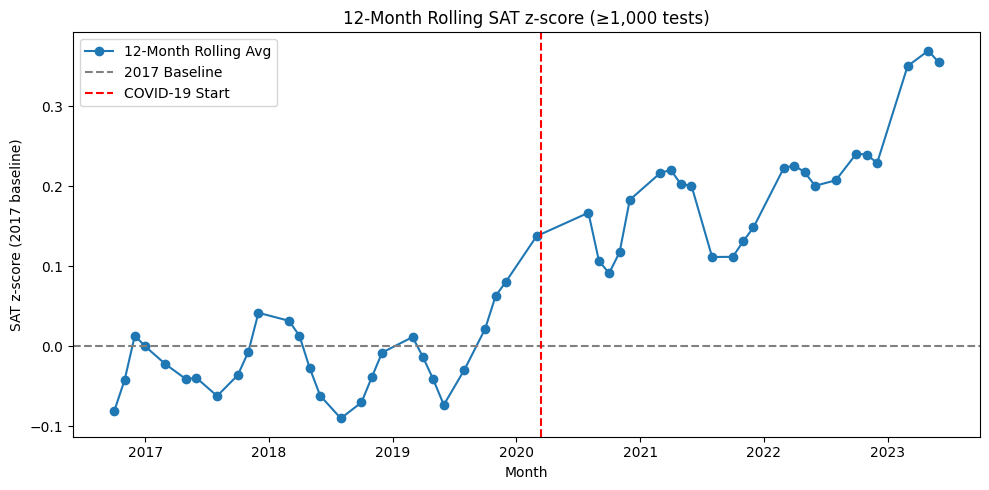

In [5]:
# 0) Sort by date
monthly = monthly.sort_values('date')

# 1) Compute a 12-month centered rolling mean 
#    min_periods=6 gives you half-a-year of data before you start plotting points
monthly['mean_z_12mo'] = (
    monthly
    .set_index('date')['mean_z']
    .rolling(window=12, min_periods=6, center=True)
    .mean()
    .reset_index(drop=True)
)

# 2) Plot the 12-month rolling average
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(monthly['date'], monthly['mean_z_12mo'], "o-", label="12-Month Rolling Avg")

# baseline & COVID start
ax.axhline(0, linestyle="--", color="gray", label="2017 Baseline")
ax.axvline(pd.to_datetime("2020-03-14"),
           color="red", linestyle="--", label="COVID-19 Start")

# format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_xlabel("Month")
ax.set_ylabel("SAT z-score (2017 baseline)")
ax.set_title("12-Month Rolling SAT z-score (≥1,000 tests)")
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
# Pre/post t‐test for z_2017
good_months = monthly['date'].dt.to_period("M")
pre  = cb_demo.loc[
    cb_demo["date"].dt.to_period("M").isin(good_months) &
    (cb_demo["year"] < POST_YEAR),
    "z_2017"
]
post = cb_demo.loc[
    cb_demo["date"].dt.to_period("M").isin(good_months) &
    (cb_demo["year"] >= POST_YEAR),
    "z_2017"
]
stat, pval = ttest_ind(post, pre, nan_policy="omit")
print(f"Mean before: {pre.mean():.4f}")
print(f"Mean after:  {post.mean():.4f}")
print(f"Difference:  {post.mean()-pre.mean():.4f}")
print(f"t-statistic: {stat:.4f}")
print(f"p-value:     {pval:.4f}")

Mean before: -0.0107
Mean after:  0.2503
Difference:  0.2610
t-statistic: 62.0486
p-value:     0.0000


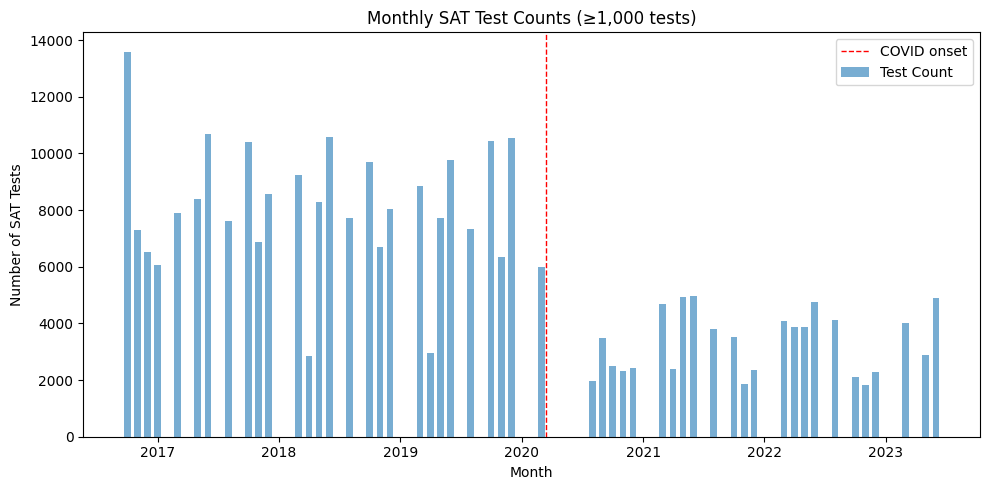

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
# 1) Create single‐axis plot for test counts
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(
    monthly['date'],
    monthly['test_count'],
    width=20,         # you may need to tweak this for your date resolution
    alpha=0.6,
    label="Test Count"
)

# 2) Add red dashed line at the March 14 2020 test date
covid_cutoff = datetime.datetime(2020, 3, 14)
ax.axvline(
    x=covid_cutoff,
    color='red',
    linestyle='--',
    linewidth=1,
    label='COVID onset'
)

# 3) Format the x‐axis by year
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# 4) Labels, title, legend
ax.set_xlabel("Month")
ax.set_ylabel("Number of SAT Tests")
ax.set_title("Monthly SAT Test Counts (≥1,000 tests)")
ax.legend()

plt.tight_layout()
plt.show()

In [8]:
# -------- Logistic regression with GPA --------
# 1) Prepare grade 11-12 roster & test data
demo_11_12 = demo.query("grade in ['11','12'] and year != 2016").copy()
cb11 = cb_full.query("year != 2016").copy()
for df_ in (demo_11_12, cb11):
    df_["mastid"] = pd.to_numeric(df_["mastid"], errors='coerce').astype('Int64')
    df_["year"]   = pd.to_numeric(df_["year"],   errors='coerce').astype('Int64')
merged = demo_11_12.merge(
    cb11[['mastid','year','sat_total_score_mr','psat_bin']],
    on=['mastid','year'], how='left', indicator=True
)
print(merged['_merge'].value_counts())

# Flag SAT participation and build PSAT dummies
merged['sat_taken'] = merged['sat_total_score_mr'].notna().astype(int)
merged['psat_bin']  = merged['psat_bin'].replace('', np.nan).fillna('Missing')
for q in ['Q1','Q2','Q3','Q4']:
    merged[f'psat_{q}'] = (merged['psat_bin'] == q).astype(int)
merged['psat_Missing'] = (merged['psat_bin']=='Missing').astype(int)

# Demographic flags and one-hot ethnicity
df_clean = merged.dropna(subset=['ethnic','eds','aig']).copy()
df_clean['AIG_flag'] = (df_clean['aig']=='Y').astype(int)
df_clean['EDS_flag'] = (df_clean['eds']=='Y').astype(int)
eth_dummies = pd.get_dummies(df_clean['ethnic'], prefix='eth', drop_first=True)
df_clean = pd.concat([df_clean, eth_dummies], axis=1)

# Merge in SAT date and baseline z-score
cb_m = cb_demo[['mastid','year','date','z_2017']].copy()
for c in ['mastid','year']:
    cb_m[c] = pd.to_numeric(cb_m[c], errors='coerce').astype('Int64')
model_df = df_clean.merge(cb_m, on=['mastid','year'], how='left').rename(columns={'z_2017':'z_score'})

# 2) Merge GPA data
# Ensure numeric keys
gpa[['mastid','year']] = gpa[['mastid','year']].apply(pd.to_numeric, errors='coerce')
gpa_clean = (
    gpa.dropna(subset=['mastid','year','gpa_weighted'])
       .drop_duplicates(subset=['mastid','year'])
)
model_df = model_df.merge(
    gpa_clean[['mastid','year','gpa_weighted']],
    on=['mastid','year'], how='inner'
).drop_duplicates(subset=['mastid','year']).reset_index(drop=True)
model_df.to_csv('cb_demo_gpa.csv', index=False)

_merge
left_only     858412
both          495112
right_only         0
Name: count, dtype: int64


In [9]:
# 1) Prep demo & SAT data (grades 11–12, drop 2016)
demo_11_12 = (demo
    .query("grade in ['11','12'] and year != 2016")
    .assign(
        mastid=lambda df: pd.to_numeric(df["mastid"], errors="coerce").astype("Int64"),
        year=lambda df: pd.to_numeric(df["year"],   errors="coerce").astype("Int64")
    )
)

cb11 = (cb_full
    .query("year != 2016")
    .assign(
        mastid=lambda df: pd.to_numeric(df["mastid"], errors="coerce").astype("Int64"),
        year=lambda df: pd.to_numeric(df["year"],   errors="coerce").astype("Int64")
    )
)

merged = demo_11_12.merge(
    cb11[['mastid','year','sat_total_score_mr','psat_bin']],
    on=['mastid','year'], how='left', indicator=True
)
print(merged['_merge'].value_counts())

# 2) Flag SAT participation + PSAT quartile dummies
merged['sat_taken'] = merged['sat_total_score_mr'].notna().astype(int)
merged['psat_bin']  = merged['psat_bin'].replace('', np.nan).fillna('Missing')
psat_dummies = pd.get_dummies(merged['psat_bin'], prefix='psat', drop_first=True)

# 3) Demographics + ethnicity dummies
df_clean = (merged
    .dropna(subset=['ethnic','eds','aig'])
    .assign(
        AIG_flag=lambda df: (df['aig']=='Y').astype(int),
        EDS_flag=lambda df: (df['eds']=='Y').astype(int)
    )
)
eth_dummies = pd.get_dummies(df_clean['ethnic'], prefix='eth', drop_first=True)

# 4) Merge SAT date & baseline z‐score
cb_m = (cb_demo[['mastid','year','date','z_2017']]
    .assign(
        mastid=lambda df: pd.to_numeric(df["mastid"], errors="coerce").astype("Int64"),
        year=lambda df: pd.to_numeric(df["year"],   errors="coerce").astype("Int64")
    )
)
model_df = (
    pd.concat([df_clean, psat_dummies, eth_dummies], axis=1)
      .merge(cb_m, on=['mastid','year'], how='left')
      .rename(columns={'z_2017':'z_score'})
)

# 5) Merge in GPA, drop continuous, create quartiles
gpa_keyed = (gpa
    .dropna(subset=['mastid','year','gpa_weighted'])
    .drop_duplicates(subset=['mastid','year'])
    .assign(
        mastid=lambda df: pd.to_numeric(df["mastid"], errors="coerce").astype("Int64"),
        year=lambda df: pd.to_numeric(df["year"],   errors="coerce").astype("Int64")
    )
)

model_df = model_df.merge(
    gpa_keyed[['mastid','year','gpa_weighted']],
    on=['mastid','year'],
    how='inner'
).reset_index(drop=True)

# now build quartiles (Q1 is the reference level)
model_df['gpa_q'] = pd.qcut(model_df['gpa_weighted'],
                            q=4,
                            labels=['Q1','Q2','Q3','Q4'])
gpa_q_dummies = pd.get_dummies(model_df['gpa_q'], prefix='gpa', drop_first=True)

model_df = pd.concat([model_df, gpa_q_dummies], axis=1)

# 6) Define predictors
base_preds = ['AIG_flag','EDS_flag'] \
           + list(psat_dummies.columns) \
           + list(eth_dummies.columns)

gpa_preds  = list(gpa_q_dummies.columns)   # e.g. ['gpa_Q2','gpa_Q3','gpa_Q4']
preds_full = base_preds + gpa_preds

# 7) Fit & compare
y  = model_df['sat_taken'].astype(float)

# Base model
X1 = sm.add_constant(model_df[base_preds]).astype(float)
mod1 = sm.Logit(y, X1).fit(disp=False)

# Full model (with quartiles)
X2 = sm.add_constant(model_df[preds_full]).astype(float)
mod2 = sm.Logit(y, X2).fit(disp=False)

# Summaries
print("=== Base Model ===")
print(mod1.summary())
print(f"AIC: {mod1.aic:.1f}\n")

print("=== Full Model (GPA quartiles) ===")
print(mod2.summary())
print(f"AIC: {mod2.aic:.1f}\n")

# Likelihood‐ratio test
t_stat  = 2*(mod2.llf - mod1.llf)
df_diff = int(mod2.df_model - mod1.df_model)
p_val   = stats.chi2.sf(t_stat, df_diff)
print(f"LR‐test p‐value: {p_val:.4f}")

# AUCs
auc1 = roc_auc_score(y, mod1.predict(X1))
auc2 = roc_auc_score(y, mod2.predict(X2))
print(f"Base AUC: {auc1:.3f}  |  Quartiles AUC: {auc2:.3f}  |  ΔAUC: {auc2-auc1:.3f}")


_merge
left_only     858412
both          495112
right_only         0
Name: count, dtype: int64
=== Base Model ===
                           Logit Regression Results                           
Dep. Variable:              sat_taken   No. Observations:              1327894
Model:                          Logit   Df Residuals:                  1327881
Method:                           MLE   Df Model:                           12
Date:                Wed, 23 Jul 2025   Pseudo R-squ.:                  0.1005
Time:                        13:49:54   Log-Likelihood:            -5.7861e+05
converged:                       True   LL-Null:                   -6.4328e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7311      0.011    -67.963      0.000      -0.752      -0.710
AIG_flag       0

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df, cols):
    """
    Compute VIFs for the columns in `cols` of DataFrame df.
    Returns a DataFrame with “variable” and “VIF” columns.
    """
    X = sm.add_constant(df[cols]).astype(float)
    vif_data = []
    for i, var in enumerate(X.columns):
        vif_data.append({
            "variable": var,
            "VIF": variance_inflation_factor(X.values, i)
        })
    return pd.DataFrame(vif_data)

# 1) VIF for the base model
vif_base = compute_vif(model_df, base_preds)
print("Base Model VIFs:\n", vif_base)

# 2) VIF for the full model (with GPA quartiles)
vif_full = compute_vif(model_df, preds_full)
print("\nFull Model VIFs:\n", vif_full)

Base Model VIFs:
     variable        VIF
0      const  31.213676
1   AIG_flag   1.094446
2   EDS_flag   1.161571
3    psat_Q1   1.018502
4    psat_Q2   1.006362
5    psat_Q3   1.011449
6    psat_Q4   1.068556
7      eth_B   6.467959
8      eth_H   5.020358
9      eth_I   1.322619
10     eth_M   2.145352
11     eth_P   1.036717
12     eth_W   7.967600

Full Model VIFs:
     variable        VIF
0      const  36.128931
1   AIG_flag   1.179175
2   EDS_flag   1.194587
3    psat_Q1   1.024471
4    psat_Q2   1.012055
5    psat_Q3   1.026066
6    psat_Q4   1.112013
7      eth_B   6.581344
8      eth_H   5.078467
9      eth_I   1.327309
10     eth_M   2.158277
11     eth_P   1.037046
12     eth_W   7.994453
13    gpa_Q2   1.529468
14    gpa_Q3   1.639407
15    gpa_Q4   1.949654


In [11]:
# -------- Propensity weighting & trimming --------
# Compute propensity scores from the GPA-augmented model
# 1) pull out just the predictors, convert to float
X_pred = model_df[preds_full].astype(float)

# 2) add the constant column (also float)
X_pred = sm.add_constant(X_pred)

# 3) predict probabilities
model_df["ps"] = mod2.predict(X_pred)

# IPT weights for SAT participation
model_df['w'] = np.where(
    model_df['sat_taken']==1,
    1/model_df['ps'],
    1/(1 - model_df['ps'])
)
# 1) Compute the 1st and 99th percentiles of the propensity score
low, high = model_df['ps'].quantile([0.01, 0.99])

# 2) Trim out the extremes
df_trim = model_df

# 3) Recompute IPT weights on the trimmed data
df_trim['w_trim'] = np.where(
    df_trim['sat_taken'] == 1,
    1/df_trim['ps'],
    1/(1 - df_trim['ps'])
)


count    1.327894e+06
mean     1.978615e+00
std      2.987295e+00
min      1.016682e+00
25%      1.064511e+00
50%      1.188371e+00
75%      1.493456e+00
max      6.094454e+01
Name: w_trim, dtype: float64
1st & 99th percentiles (trimmed): {0.01: 1.017464674234834, 0.99: 15.069167625779961}


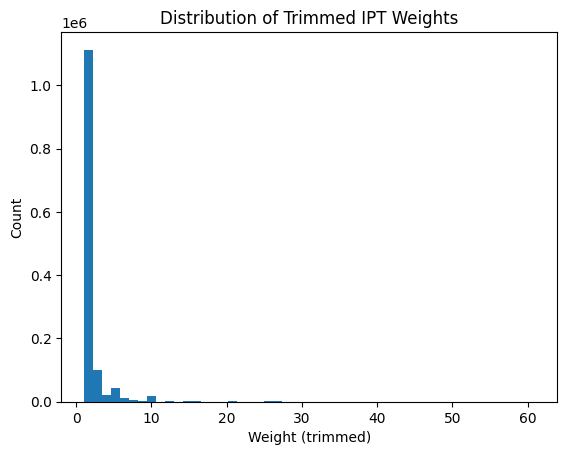

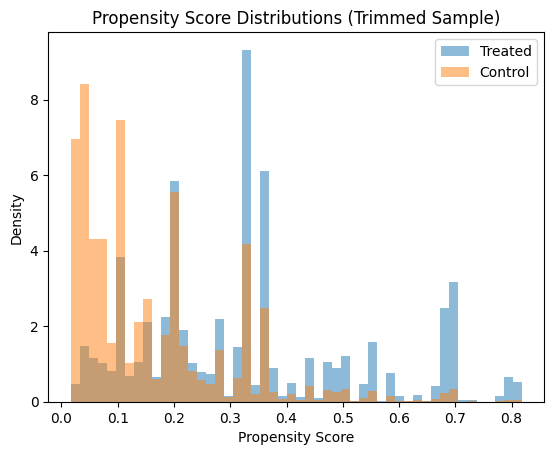

In [12]:
# 1) Weight distribution summary (trimmed)
print(df_trim['w_trim'].describe())
print("1st & 99th percentiles (trimmed):", df_trim['w_trim'].quantile([0.01, 0.99]).to_dict())

# 2) Histogram of trimmed weights
plt.figure()
plt.hist(df_trim['w_trim'], bins=50)
plt.title('Distribution of Trimmed IPT Weights')
plt.xlabel('Weight (trimmed)')
plt.ylabel('Count')
plt.show()

# 3) Propensity‐score overlap on trimmed data
treated_ps_trim = df_trim.loc[df_trim['sat_taken'] == 1, 'ps']
control_ps_trim = df_trim.loc[df_trim['sat_taken'] == 0, 'ps']

plt.figure()
plt.hist(treated_ps_trim, bins=50, density=True, alpha=0.5, label='Treated')
plt.hist(control_ps_trim, bins=50, density=True, alpha=0.5, label='Control')
plt.title('Propensity Score Distributions (Trimmed Sample)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [18]:
from statsmodels.stats.weightstats import DescrStatsW
CUT_OFF_DATE = pd.to_datetime("2020-03-14")
# 1) Restrict to SAT‑takers
df_tt = df_trim[df_trim['sat_taken']==1].copy()

# 2) Flag post‑COVID
df_tt['post'] = (df_tt['date'] >= CUT_OFF_DATE).astype(int)

# 3) Fit logistic model for period
Xp = sm.add_constant(df_tt[preds_full].astype(float))
mod_period = sm.Logit(df_tt['post'], Xp).fit(disp=False)
df_tt['p_post'] = mod_period.predict(Xp)

# 4) ATT period weights (post=1, pre=p/(1-p))
df_tt['w_period_att'] = np.where(
    df_tt['post']==1,
    1.0,
    df_tt['p_post'] / (1 - df_tt['p_post'])
)

# 5) Combine with trimmed SAT‑selection weights
df_tt['w_final'] = df_tt['w_trim'] * df_tt['w_period_att']

# 6) (Optional) Re‑check balance on X
for cov in preds_full:
    ds_pre  = DescrStatsW(df_tt.loc[df_tt['post']==0, cov],
                          weights=df_tt.loc[df_tt['post']==0, 'w_final'])
    ds_post = DescrStatsW(df_tt.loc[df_tt['post']==1, cov],
                          weights=df_tt.loc[df_tt['post']==1, 'w_final'])
    smd = (ds_post.mean - ds_pre.mean) / np.sqrt((ds_post.var + ds_pre.var)/2)
    print(f"{cov}: |SMD| = {abs(smd):.3f}")

# 7) Estimate the ATT: weighted means & WLS for SEs
y, wt = 'sat_total_score_mr', 'w_final'
mean_post = np.average(df_tt.loc[df_tt['post']==1, y],
                       weights=df_tt.loc[df_tt['post']==1, wt])
mean_pre  = np.average(df_tt.loc[df_tt['post']==0, y],
                       weights=df_tt.loc[df_tt['post']==0, wt])
att = mean_post - mean_pre

print(f"\nWeighted mean (Post‑COVID): {mean_post:.2f}")
print(f"Weighted mean (Pre‑COVID):  {mean_pre:.2f}")
print(f"\nATT (Post vs Pre among testers): {att:.2f} points\n")



AIG_flag: |SMD| = 0.021
EDS_flag: |SMD| = 0.019
psat_Q1: |SMD| = 0.032
psat_Q2: |SMD| = 0.022
psat_Q3: |SMD| = 0.011
psat_Q4: |SMD| = 0.011
eth_B: |SMD| = 0.001
eth_H: |SMD| = 0.012
eth_I: |SMD| = 0.003
eth_M: |SMD| = 0.010
eth_P: |SMD| = 0.006
eth_W: |SMD| = 0.010
gpa_Q2: |SMD| = 0.005
gpa_Q3: |SMD| = 0.008
gpa_Q4: |SMD| = 0.007

Weighted mean (Post‑COVID): 1045.21
Weighted mean (Pre‑COVID):  1033.73

ATT (Post vs Pre among testers): 11.48 points



In [20]:
# 1) Raw full‑sample (no trimming, no weighting)
raw_pre  = model_df.loc[model_df['date'] < CUT_OFF_DATE, 'sat_total_score_mr']
raw_post = model_df.loc[model_df['date'] >= CUT_OFF_DATE, 'sat_total_score_mr']

print("Raw pre‑COVID mean:   ", raw_pre.mean())
print("Raw pre‑COVID median: ", raw_pre.median())
print("Raw post‑COVID mean:  ", raw_post.mean())
print("Raw post‑COVID median:", raw_post.median(), "\n")

# 2) Trimmed only (1%–99%), unweighted
trim_pre  = df_tt.loc[df_tt['post']==0, 'sat_total_score_mr']
trim_post = df_tt.loc[df_tt['post']==1, 'sat_total_score_mr']

print("Trimmed unweighted pre‑COVID mean:  ", trim_pre.mean())
print("Trimmed unweighted post‑COVID mean: ", trim_post.mean(), "\n")

# 3) Fully trimmed + re‑weighted
wt_pre  = np.average(
    df_tt.loc[df_tt['post']==0, 'sat_total_score_mr'],
    weights=df_tt.loc[df_tt['post']==0, 'w_final']
)
wt_post = np.average(
    df_tt.loc[df_tt['post']==1, 'sat_total_score_mr'],
    weights=df_tt.loc[df_tt['post']==1, 'w_final']
)

print("Weighted pre‑COVID mean:  ", wt_pre)
print("Weighted post‑COVID mean: ", wt_post)
print(">>> ATT (Post – Pre):      ", wt_post - wt_pre, "points")


Raw pre‑COVID mean:    1088.6987229667363
Raw pre‑COVID median:  1080.0
Raw post‑COVID mean:   1138.5773953301127
Raw post‑COVID median: 1140.0 

Trimmed unweighted pre‑COVID mean:   1088.6987229667363
Trimmed unweighted post‑COVID mean:  1138.5773953301127 

Weighted pre‑COVID mean:   1033.7345473987418
Weighted post‑COVID mean:  1045.2099332934054
>>> ATT (Post – Pre):       11.475385894663532 points


Original ATT estimate: 11.48 points
95% bootstrap CI: [9.00, 13.93] points


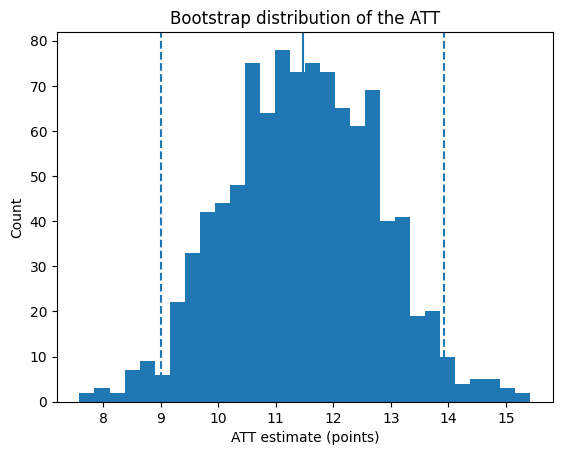

In [25]:
# ─── Bootstrap ATT estimation ──────────────────────────────────────────────
# Number of bootstrap replicates
n_boot = 1000

# Prepare storage
atts = np.zeros(n_boot)

# Define outcome and weight columns
y_col  = 'sat_total_score_mr'
w_col  = 'w_final'
post_col = 'post'

# Perform bootstrap
for i in range(n_boot):
    # 1) Draw a bootstrap sample of the same size as df_tt
    boot = df_tt.sample(n=len(df_tt), replace=True)
    
    # 2) Compute weighted means in each period
    mean_pre  = np.average(
        boot.loc[boot[post_col]==0, y_col],
        weights=boot.loc[boot[post_col]==0, w_col]
    )
    mean_post = np.average(
        boot.loc[boot[post_col]==1, y_col],
        weights=boot.loc[boot[post_col]==1, w_col]
    )
    
    # 3) Store the ATT for this replicate
    atts[i] = mean_post - mean_pre

# 4) Compute the 95% CI
ci_lower, ci_upper = np.percentile(atts, [2.5, 97.5])

# 5) Report
orig_att = (np.average(df_tt.loc[df_tt[post_col]==1, y_col],
                       weights=df_tt.loc[df_tt[post_col]==1, w_col])
            - np.average(df_tt.loc[df_tt[post_col]==0, y_col],
                         weights=df_tt.loc[df_tt[post_col]==0, w_col]))

print(f"Original ATT estimate: {orig_att:.2f} points")
print(f"95% bootstrap CI: [{ci_lower:.2f}, {ci_upper:.2f}] points")

# --- (2) Plot the bootstrap distribution ---
plt.figure()
plt.hist(atts, bins=30)
plt.xlabel('ATT estimate (points)')
plt.ylabel('Count')
plt.title('Bootstrap distribution of the ATT')
# mark the CI
plt.axvline(ci_lower, linestyle='--')
plt.axvline(ci_upper, linestyle='--')
# optional: mark the original estimate
plt.axvline(orig_att, linestyle='-')
plt.show()


Bootstrap ATT: 11.51 points (95% CI: 9.10–14.00)


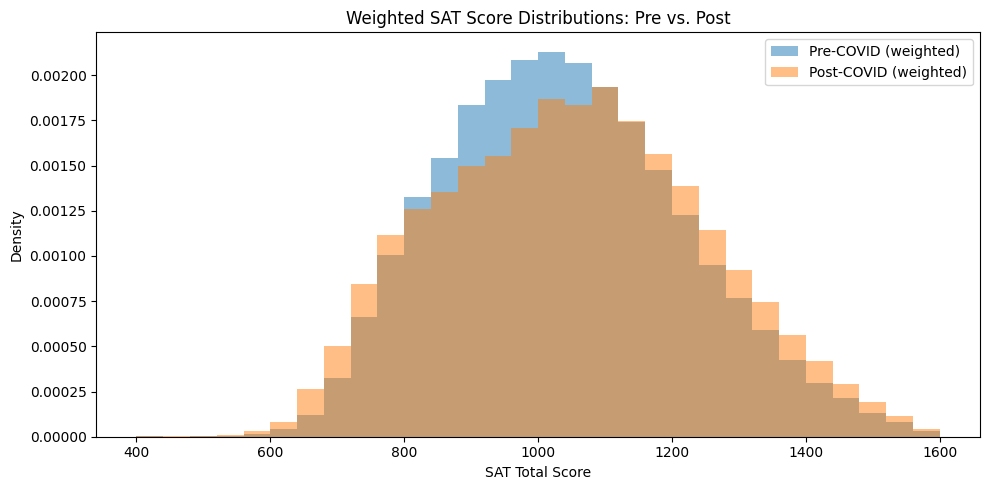

In [26]:
# 8) Bootstrap ATT‐weighted ATT estimate for a 95% confidence interval
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt

# If your final ATT weights are in df_tt['w_final'], alias them here:
df_tt['w_ATT'] = df_tt['w_final']

n_boot = 500  # number of bootstrap samples
boot_atts = []

for _ in range(n_boot):
    # draw a bootstrap sample of the tester‐only data
    boot_df = resample(df_tt, replace=True, n_samples=len(df_tt), random_state=None)

    # split into pre/post
    boot_pre  = boot_df[boot_df['post']==0].dropna(subset=['sat_total_score_mr','w_ATT'])
    boot_post = boot_df[boot_df['post']==1].dropna(subset=['sat_total_score_mr','w_ATT'])

    # skip if a group has zero total weight
    if boot_pre['w_ATT'].sum() == 0 or boot_post['w_ATT'].sum() == 0:
        continue

    # compute weighted means
    mean_pre  = np.average(boot_pre['sat_total_score_mr'], weights=boot_pre['w_ATT'])
    mean_post = np.average(boot_post['sat_total_score_mr'], weights=boot_post['w_ATT'])

    # store the ATT (post – pre)
    boot_atts.append(mean_post - mean_pre)

# compute 95% CI
ci_lower, ci_upper = np.percentile(boot_atts, [2.5, 97.5])
print(f"Bootstrap ATT: {np.mean(boot_atts):.2f} points "
      f"(95% CI: {ci_lower:.2f}–{ci_upper:.2f})")

# 9) Plot weighted SAT score distributions: Pre vs. Post
plt.figure(figsize=(10,5))

pre_mask  = df_tt['post']==0
post_mask = df_tt['post']==1

plt.hist(
    df_tt.loc[pre_mask, 'sat_total_score_mr'],
    weights=df_tt.loc[pre_mask, 'w_ATT'],
    bins=30, density=True, alpha=0.5,
    label='Pre-COVID (weighted)'
)
plt.hist(
    df_tt.loc[post_mask, 'sat_total_score_mr'],
    weights=df_tt.loc[post_mask, 'w_ATT'],
    bins=30, density=True, alpha=0.5,
    label='Post-COVID (weighted)'
)

plt.title('Weighted SAT Score Distributions: Pre vs. Post')
plt.xlabel('SAT Total Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# Recompute post on the full model_df by academic year
model_df['post'] = (model_df['year'] >= POST_YEAR).astype(int)

# Overall pre vs. post counts
print(model_df['post'].value_counts())

# Quartile counts before trimming, using full-sample GPA breakpoints
model_df['gpa_q_full'] = pd.qcut(
    model_df['gpa_weighted'],
    q=4,
    labels=['Q1','Q2','Q3','Q4']
)

print(pd.crosstab(
    model_df['gpa_q_full'],
    model_df['post'],
    rownames=['GPA Quartile'],
    colnames=['Post?']
))

post
0    691033
1    636861
Name: count, dtype: int64
Post?              0       1
GPA Quartile                
Q1            168667  163480
Q2            161110  170698
Q3            166270  173812
Q4            194986  128871
